<a href="https://colab.research.google.com/github/JaredDRodriguez/Notebook_PDI_LAB/blob/main/PIA_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final: Algortimo de Segmentación

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Leer y convertir a escala de grises
img_color = cv2.imread(filename)
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)



Saving Tumor3.jpg to Tumor3.jpg


Histogramas

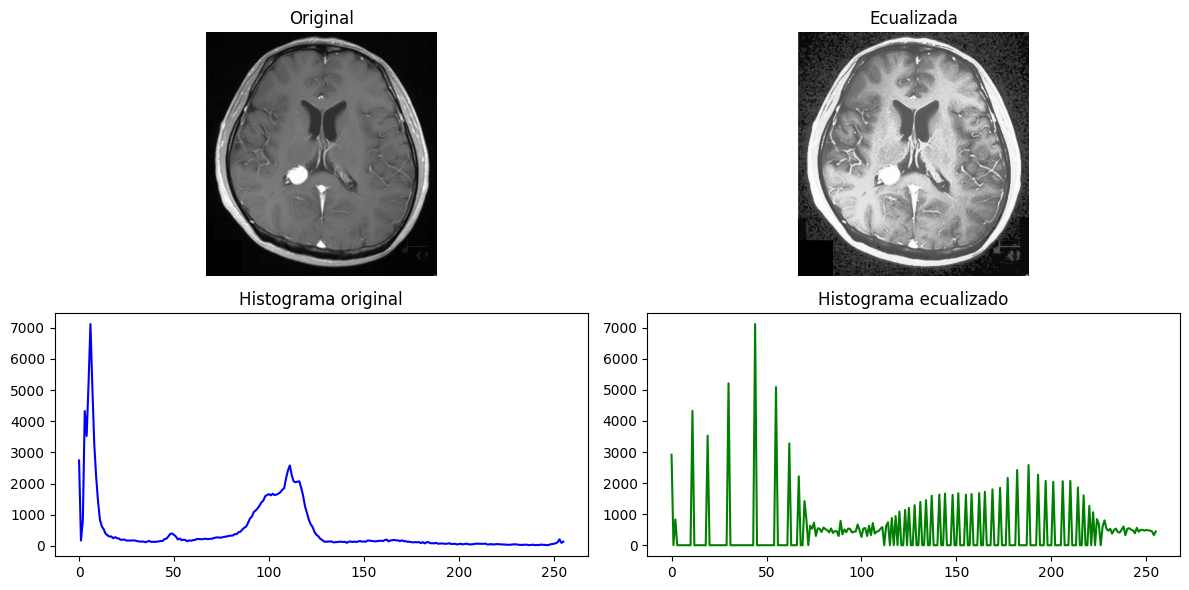

In [ ]:
#Esta celda va a mostrar el histograma de la img original y luego ecualizarlo, comparar ambas
hist_orig = cv2.calcHist([img], [0], None, [256], [0,256])
img_eq = cv2.equalizeHist(img)
hist_eq = cv2.calcHist([img_eq], [0], None, [256], [0,256])

plt.figure(figsize=(12,6))
plt.subplot(2,2,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(2,2,2); plt.imshow(img_eq, cmap='gray'); plt.title("Ecualizada"); plt.axis("off")
plt.subplot(2,2,3); plt.plot(hist_orig, color='blue'); plt.title("Histograma original")
plt.subplot(2,2,4); plt.plot(hist_eq, color='green'); plt.title("Histograma ecualizado")
plt.tight_layout(); plt.show()

Operaciones aritméticas y lógicas.

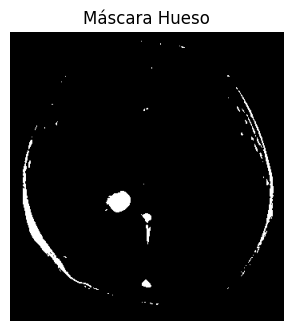

In [ ]:
#Mascaras para eliminar hueso

# --- Máscara para descartar hueso ---
# 210
_, mask_hueso = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)

#invertir
mask_master_inv = cv2.bitwise_not(mask_hueso)

# Mostrar (opcional en Colab)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 2)
plt.title("Máscara Hueso")
plt.imshow(mask_hueso, cmap='gray')
plt.axis('off')


plt.show()


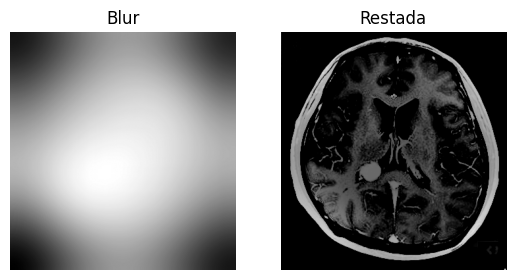

In [ ]:
#Genear imagen con blur para resaltar bordes restando
#kernel alto para no perder tantos detalles
img_blur = cv2.GaussianBlur(img_eq, (333, 333), 0)
img_rest = cv2.subtract(img_eq, img_blur)
# Mostrar ambas imágenes
plt.subplot(1, 2, 1)
plt.imshow(img_blur, cmap='gray')
plt.title('Blur')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_rest, cmap='gray')
plt.title('Restada')
plt.axis('off')

plt.show()



In [ ]:
#Celda para encontrar el valor ideal para mostrar el tumor {54}
from ipywidgets import interact, IntSlider

def segmentar_umbral(umbral):
    _, binarizada = cv2.threshold(img_rest, umbral, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_rest, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(binarizada, cmap='gray'); plt.title(f"Segmentada (umbral={umbral})"); plt.axis("off")
    plt.show()

interact(segmentar_umbral, umbral=IntSlider(min=0, max=255, step=1, value=54))

interactive(children=(IntSlider(value=30, description='umbral', max=255), Output()), _dom_classes=('widget-int…

<function __main__.segmentar_umbral(umbral)>

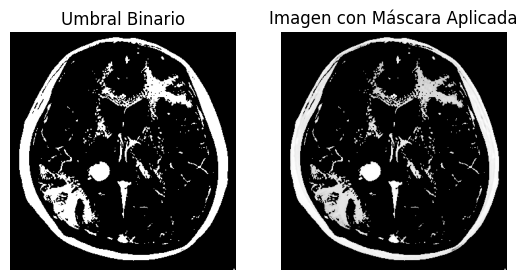

In [ ]:
#Generar mascaras para definir las zonas de interes

_, img_thresh = cv2.threshold(img_rest, 54, 255, cv2.THRESH_BINARY)

# Paso 5: Aplicación de máscara (solo zonas destacadas)
masked = cv2.bitwise_and(img_eq, img_eq, mask=img_thresh)

plt.subplot(1, 2, 1)
plt.title('Umbral Binario')
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen con Máscara Aplicada')
plt.imshow(masked, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
#Celda para encontrar el valor ideal para mostrar hueso pero sin el tumor {80)
from ipywidgets import interact, IntSlider

def segmentar_umbral(umbral):
    _, binarizada = cv2.threshold(img_rest, umbral, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(img_rest, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(binarizada, cmap='gray'); plt.title(f"Segmentada (umbral={umbral})"); plt.axis("off")
    plt.show()

interact(segmentar_umbral, umbral=IntSlider(min=0, max=255, step=1, value=225))

interactive(children=(IntSlider(value=225, description='umbral', max=255), Output()), _dom_classes=('widget-in…

<function __main__.segmentar_umbral(umbral)>

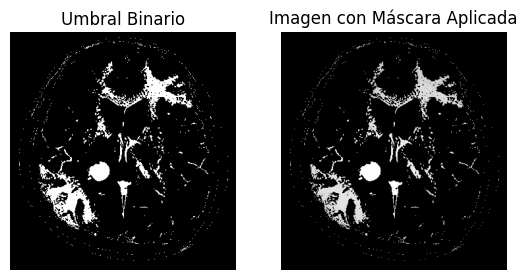

In [ ]:
#Mascaras para eliminar hueso

# --- Máscara para descartar hueso ---
# 80
_, mask_hueso = cv2.threshold(img_rest, 80, 255, cv2.THRESH_BINARY)
#añadir a la mascara anterior

mask_master = cv2.bitwise_xor(img_thresh, mask_hueso)

# Aplicación de máscara (solo zonas destacadas)
img_mask = cv2.bitwise_and(img_eq, img_eq, mask=mask_master)

plt.subplot(1, 2, 1)
plt.title('Umbral Binario')
plt.imshow(mask_master, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Imagen con Máscara Aplicada')
plt.imshow(img_mask, cmap='gray')
plt.axis('off')

plt.show()


Filtros Paso-Alto y Paso Bajos

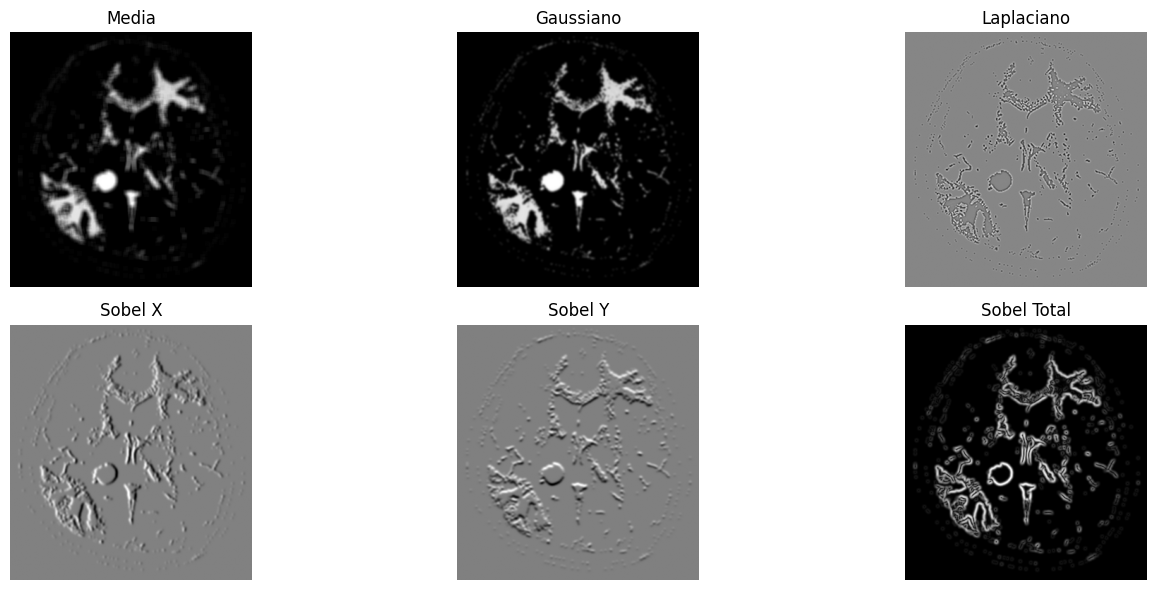

In [ ]:
#Filtro paso bajo
kernelg = 7
#media = cv2.blur(img_mask, (kernelg,kernelg))
gauss = cv2.GaussianBlur(img_mask, (kernelg,kernelg), 0)

#Filtro paso alto
sobelx = cv2.Sobel(gauss, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gauss, cv2.CV_64F, 0, 1, ksize=3)
sobel_total = np.hypot(sobelx, sobely)
##laplacian = cv2.Laplacian(gauss, cv2.CV_64F)
laplacian_abs = cv2.convertScaleAbs(laplacian)
sobel_total = np.hypot(sobelx, sobely)
sobel_total = cv2.normalize(sobel_total, None, 0, 255, cv2.NORM_MINMAX)
sobel_total_uint8 = sobel_total.astype(np.uint8)

plt.figure(figsize=(15,6))
plt.subplot(2,3,1); plt.imshow(media, cmap='gray'); plt.title("Media"); plt.axis("off")
plt.subplot(2,3,2); plt.imshow(gauss, cmap='gray'); plt.title("Gaussiano"); plt.axis("off")
plt.subplot(2,3,3); plt.imshow(laplacian, cmap='gray'); plt.title("Laplaciano"); plt.axis("off")
plt.subplot(2,3,4); plt.imshow(sobelx, cmap='gray'); plt.title("Sobel X"); plt.axis("off")
plt.subplot(2,3,5); plt.imshow(sobely, cmap='gray'); plt.title("Sobel Y"); plt.axis("off")
plt.subplot(2,3,6); plt.imshow(sobel_total, cmap='gray'); plt.title("Sobel Total"); plt.axis("off")
plt.tight_layout(); plt.show()

Área total estimada del tumor: 891.0 pixeles²


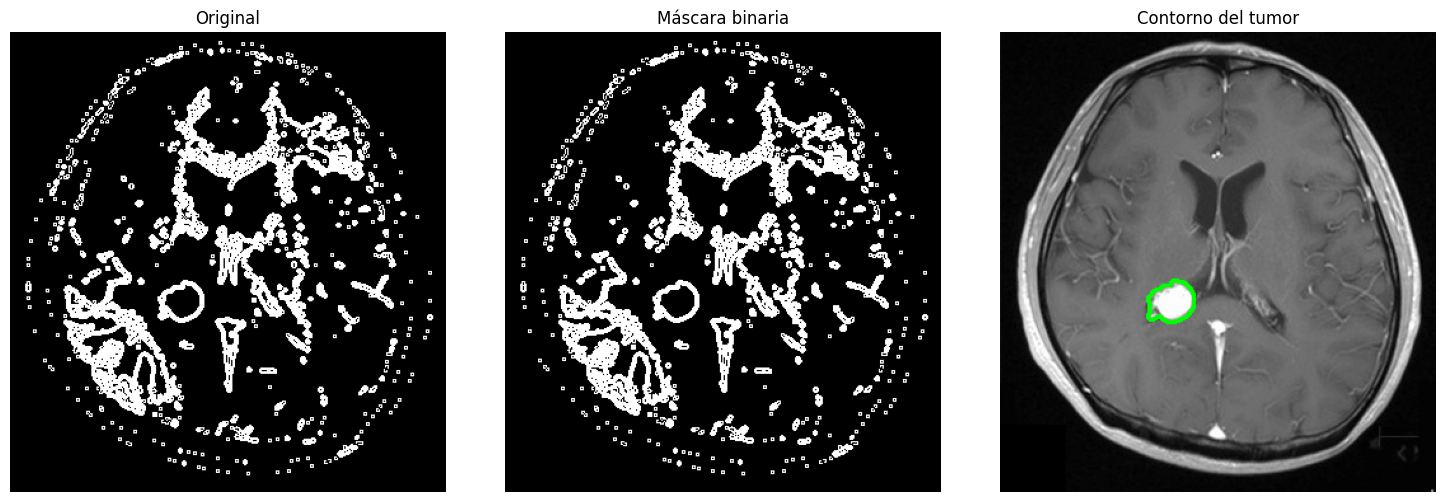

In [ ]:



# Se hace una mascara binaria de sobel, se dilatan los bordes y se cierran
_, mask_bin = cv2.threshold(sobel_total_uint8, 30, 255, cv2.THRESH_BINARY)
kernel = np.ones((1, 1), np.uint8)
dilated = cv2.dilate(mask_bin, kernel, iterations=1)
closed = cv2.morphologyEx(mask_bin, cv2.MORPH_CLOSE, kernel, iterations=10)

# Encontrar contornos
contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtrar contornos por área y circularidad
output = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
tumor_areas = []
for cnt in contours:
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue
    circularity = 4 * np.pi * area / (perimeter ** 2)
    if area > 300 and 0.4 < circularity < 2.2: #Si detecta el craneo como totalidad bajar estos valores, o usar mascara para eliminar hueso
        cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
        tumor_areas.append(area)

#Calcular área total (en pixeles)
area_total = sum(tumor_areas)
print("Área total estimada del tumor:", area_total, "pixeles²")

#Visualizar resultados
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(mask_bin, cmap='gray'); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(closed, cmap='gray'); plt.title("Máscara binaria"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(output); plt.title("Contorno del tumor"); plt.axis("off")
plt.tight_layout(); plt.show()

#Transformada de Fourier

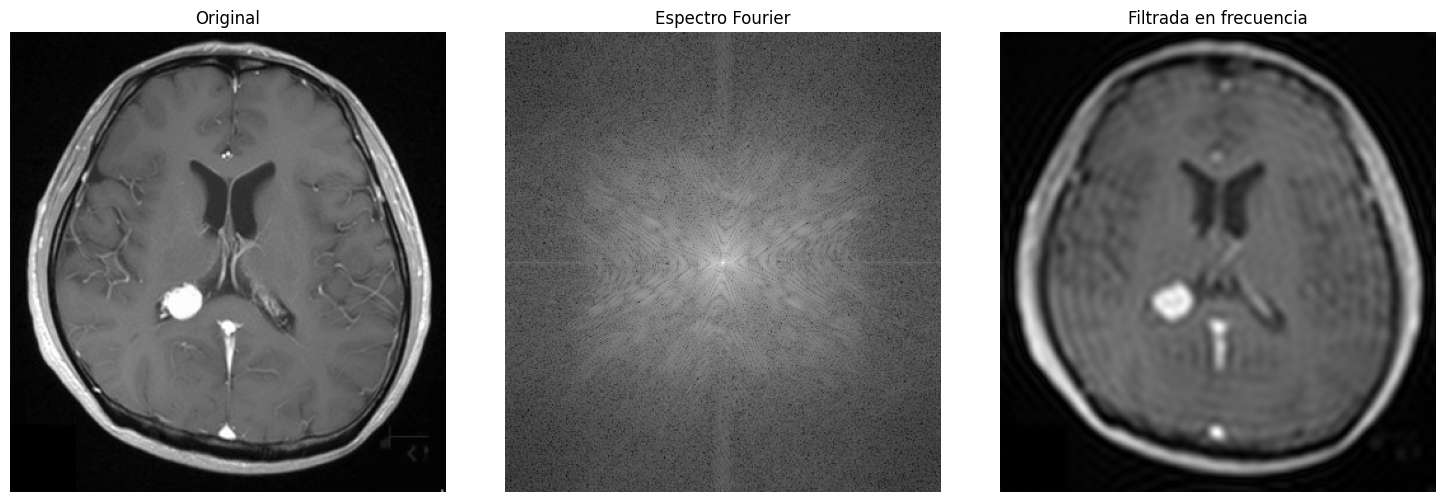

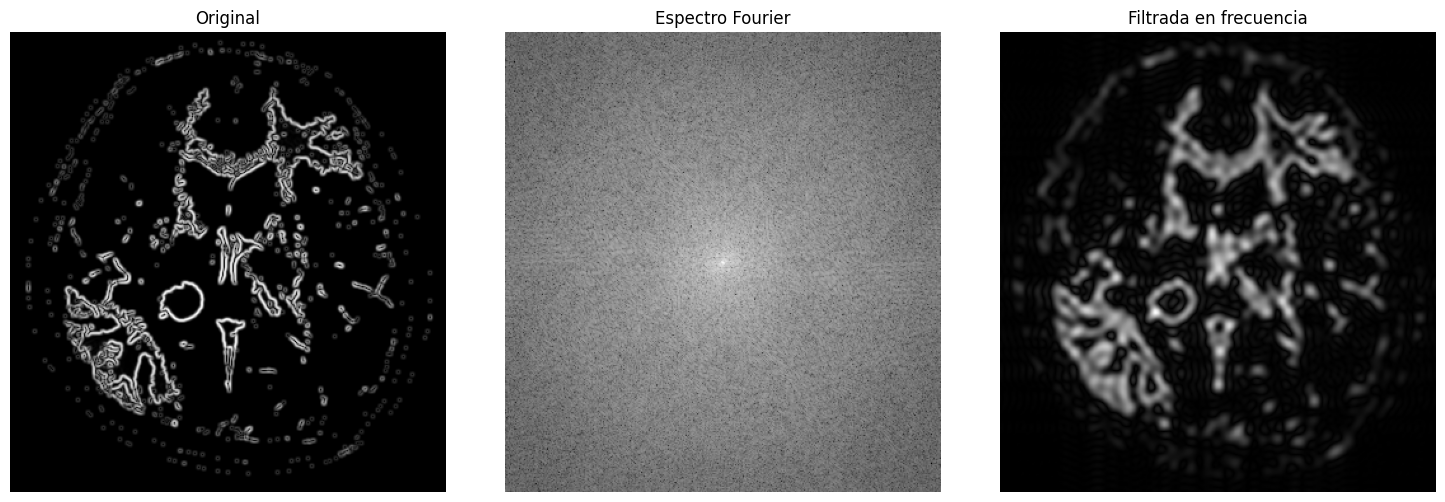

In [ ]:
def mostrar_fourier(img_gray):
    #fastfourier trsnform
    f = np.fft.fft2(img_gray)
    fshift = np.fft.fftshift(f)
    #Magnitud
    magnitude = 20 * np.log(np.abs(fshift) + 1)

    #Generar mascara de filtro, bajar kernel para hacerlo mas fuerte, mas alyo el valor del kernel para hacerlo mas debil
    rows, cols = img_gray.shape
    crow, ccol = rows//2 , cols//2
    mask = np.zeros_like(img_gray)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1

    #Aplicar filtro
    fshift_filtered = fshift * mask
    f_ishift = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.abs(np.fft.ifft2(f_ishift))

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img_gray, cmap='gray'); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(magnitude, cmap='gray'); plt.title("Espectro Fourier"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(img_filtered, cmap='gray'); plt.title("Filtrada en frecuencia"); plt.axis("off")
    plt.tight_layout(); plt.show()

mostrar_fourier(img)
mostrar_fourier(sobel_total_uint8)

